# Under-Representation Bias (w/ Synthetic Data)

This notebook recreates the finding that Equalized Odds constrained model can recover from under-representation bias.

### Setup

Please run the code block below to install the necessary packages (if needed).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.base import clone

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from collections import Counter

import fairlearn
from fairlearn.metrics import *
from fairlearn.reductions import *
import aif360

import copy, random

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Synthetic Dataset Generation

## Parameters (User Input)

In [2]:
'''

r is the proportion of training examples in the minority group, 

which means 1-r is proportion of examples in the majority group

eta is the probability of flipping the label

n is the number of training examples

beta is the probability of keeping a positively labeled example
from the minority class

NOTE: results can be replicated if and only if the following condition holds:

(1-r)(1-2*eta) + r((1-eta)*beta - eta) > 0

'''
def get_params(r = 1/3, eta = 1/4, n = 2000, beta = 0.5):
    return r, eta, n, beta

r, eta, n, beta = get_params(r = 1/3, eta = 0, n = 30000)

In [3]:
# check if above constraint holds
def check_constraints(r, eta, beta):
    first = (1-r)*(1-2*eta)
    second = r * ((1-eta)*beta - eta)
    res = first + second
    print("constraint: ", res)
    print("yes!", r, eta, beta) if res > 0 else print("no", r, eta, beta)
    
bias_amts = np.divide(list(range(10, -1, -1)),10)
np.random.seed(42)

for beta in bias_amts:
    check_constraints(r=r, eta=0.4, beta=beta)

constraint:  0.19999999999999998
yes! 0.3333333333333333 0.4 1.0
constraint:  0.18
yes! 0.3333333333333333 0.4 0.9
constraint:  0.15999999999999998
yes! 0.3333333333333333 0.4 0.8
constraint:  0.13999999999999999
yes! 0.3333333333333333 0.4 0.7
constraint:  0.11999999999999998
yes! 0.3333333333333333 0.4 0.6
constraint:  0.09999999999999999
yes! 0.3333333333333333 0.4 0.5
constraint:  0.07999999999999999
yes! 0.3333333333333333 0.4 0.4
constraint:  0.06
yes! 0.3333333333333333 0.4 0.3
constraint:  0.039999999999999994
yes! 0.3333333333333333 0.4 0.2
constraint:  0.01999999999999999
yes! 0.3333333333333333 0.4 0.1
constraint:  0.0
no 0.3333333333333333 0.4 0.0


## True Label Generation

In [4]:
# create minority and majority groups
def get_cat_features(n, r):
    num_minority = int(r * n)
    num_majority = n - num_minority
    
    minority = np.zeros((num_minority, 1))
    majority = np.ones((num_majority, 1))
    
    cat_features = np.vstack((minority, majority))
    #np.random.shuffle(cat_features) # this is what causes us to not recover coeffs
    
    return cat_features

In [5]:
# return labels from Bayes Optimal Classifier
def get_bayes_optimal_labels(features, effect_param, threshold = 0.5):
    outcome_continuous = 1/(1+np.exp(-np.matmul(features, effect_param)))
    return outcome_continuous, np.random.binomial(1,outcome_continuous) # bernoulli to simulate LR's probabilistic nature
    #return outcome_continuous, np.where(outcome_continuous < threshold, 0, 1)

# flip labels with probability eta
def flip_labels(df_synthetic, eta):
    random.seed(42)
    labels = df_synthetic['outcome']
    #print('Before:', df_synthetic['outcome'].value_counts())
    num_flipped = 0
    for i in range(len(labels)):
        if random.uniform(0,1) <= eta:
            labels[i] = 1 if labels[i] == 0 else 0
            num_flipped += 1
    df_synthetic['outcome'] = labels
    #print('After:', df_synthetic['outcome'].value_counts())
    #print('Num Flipped: ', num_flipped, "\tRate: ", num_flipped / len(df_synthetic))
    return df_synthetic

def flip_labels2(df_majority, eta_maj, df_minority, eta_min):
    labels_maj = df_majority['outcome'].values
    labels_min = df_minority['outcome'].values
    random.seed(42)
    
    num_flipped_maj = 0
    for i in range(len(labels_maj)):
        if random.uniform(0,1) <= eta_maj:
            labels_maj[i] = 1 if labels_maj[i] == 0 else 0
            num_flipped_maj += 1
    df_majority['outcome'] = labels_maj
    print('Num Flipped Maj: ', num_flipped_maj, "\tRate: ", num_flipped_maj / len(df_majority))
    
    num_flipped_min = 0
    for i in range(len(labels_min)):
        if random.uniform(0,1) <= eta_min:
            labels_min[i] = 1 if labels_min[i] == 0 else 0
            num_flipped_min += 1
    df_minority['outcome'] = labels_min
    print('Num Flipped Min: ', num_flipped_min, "\tRate: ", num_flipped_min / len(df_minority))
    
    df_concat = pd.concat([df_majority, df_minority])
    return df_concat.sample(frac=1, random_state = 42) # permute data

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'
'''

create synthetic data with:
    3 numerical features (Gaussian), 1 categorical (sensitive attribute) 
    logistic outcome model s.t. outcome = Indicator[logit(effect_param*features) >= 0.5]
    
create minority/majority groups according to r param

simulate Bayes Optimal Classifiers for minority and majority

flip labels according to eta param

ensure equal base rates (proportion of positive examples) across both groups

'''

def true_label_generation(r, eta, n, maj_means = [0,0,0]):

    ''' 
    delete this variable to allow user to control percentage of positively labeled examples
    eg: let outcome_continuous >= 0.2 implies 80% positively labeled samples
    '''
    # causal effect params
    maj_params = [-0.7, 0.5, 1.5]
    effect_param_min = [0.5, -0.2, 0.1]
    #effect_param_maj = [i + np.random.uniform(low = -1, high = 1) for i in maj_params]
    effect_param_maj = maj_params
    
    
    num_min = int(n*r)
    num_maj = n - num_min

    # required: len(cat_probabilities) = n_cat_features
    n_cat_features = 2
    cat_probabilities = [0.5, 0.5] 

    # numerical feature params
    means = [0, 0, 0]
    cov_matrix = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

    # features
    cat_features = get_cat_features(r=r, n=n)
    
    num_features_min = np.random.multivariate_normal(means, cov_matrix, num_min)
    #num_features_min = np.random.normal(0, 1, num_min)
    num_features_maj = np.random.multivariate_normal(maj_means, cov_matrix, num_maj)
    # num_features_maj = np.array([i + np.random.uniform(low = -15, high = 10) for i in num_features_maj])
    #num_features_min = np.random.normal(0, 1, num_min)

    num_features = np.concatenate((num_features_min, num_features_maj))

    # outcomes
    outcome_continuous_min, outcome_binary_min = get_bayes_optimal_labels(features=num_features_min, effect_param=effect_param_min, threshold = 0.5)
    #outcome_binary_min = np.where(np.matmul(num_features_min, effect_param_min) > 0.5, 1, 0)
    outcome_continuous_maj, outcome_binary_maj = get_bayes_optimal_labels(features=num_features_maj, effect_param=effect_param_maj, threshold = 0.5)
    #outcome_binary_maj = np.where(np.matmul(num_features_maj, effect_param_maj) > 0.5, 1, 0)
    
    outcome = np.hstack((outcome_binary_min,outcome_binary_maj)).reshape(n,1)
    outcome_continuous = np.hstack((outcome_continuous_min,outcome_continuous_maj)).reshape(n,1)
    temp_data = np.hstack((num_features,cat_features, outcome))
    #print(outcome_continuous)
    #print(np.where(outcome_continuous < 0.5, 0, 1))
    np.random.seed(42)
    np.random.shuffle(temp_data) # randomly shuffle the data
    
    df_synthetic = pd.DataFrame(temp_data)
    df_synthetic.columns = ['num1','num2','num3','cat','outcome']
    
    df_majority = df_synthetic[df_synthetic['cat'] == 1]
    df_minority = df_synthetic[df_synthetic['cat'] == 0]
    
    #print('% Positive Majority: ', df_majority['outcome'].value_counts()[1] / len(df_majority))
    #print('\n% Positive Minority: ', df_minority['outcome'].value_counts()[1] / len(df_minority))
    print('Diff: ', df_majority['outcome'].value_counts()[1] / len(df_majority)- df_minority['outcome'].value_counts()[1] / len(df_minority))
    #print('\nTotal: ', df_majority['outcome'].value_counts())
    
    df_synthetic = flip_labels(df_synthetic, eta)
    
    # uncomment below to add diff eta for majority/minority
    #df_synthetic = flip_labels2(df_majority, 0.2, df_minority, eta) # group dependent label noise
    
    return outcome_continuous, df_synthetic 

outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n, maj_means = [0,0,0])

Diff:  0.004574999999999996


# Preparation

### Data Preprocessing

In [7]:
# split into train and test
df_train = df_synthetic.loc[range(0,int(n/2)), :]
# if original dataset has odd number of samples, remove 1 sample to be even
if (n % 2 == 1):
    df_test = df_synthetic.loc[range(int(n/2)+1, n), :]
else:
    df_test = df_synthetic.loc[range(int(n/2), n), :]

df_fidel = df_synthetic.loc[range(n, len(df_synthetic)),:]
outcome_cts = outcome_continuous[n:len(df_synthetic)]
    
df_test_maj = df_test[df_test['cat'] == 1]
df_test_min = df_test[df_test['cat'] == 0]

# format data
X_true = df_test.iloc[:, :-1].values
y_true = df_test.iloc[:, -1].values

X_true_maj = df_test_maj.iloc[:, :-1].values
y_true_maj = df_test_maj.iloc[:, -1].values
X_true_min = df_test_min.iloc[:, :-1].values
y_true_min = df_test_min.iloc[:, -1].values

sens_attrs_true = [df_test['cat']]

# Bias Injection

In [8]:
# measurement bias
def inject_noise_num(df, feature, eps = 1):
    for i in range(len(df[feature])):
        df[feature].iloc[i] += np.random.normal(0, 1) * eps # standard normal

    return df

In [9]:
from numpy import percentile
def under_sample(df_minority_positive, beta):
    X_min = df_minority_positive.iloc[:, :].values
    
    # keep each example with probability beta
    num_dropped = 0
    for i in range(len(X_min)):
        if random.uniform(0,1) > beta:
            X_min = np.delete(X_min, 0, axis=0)
            num_dropped += 1
    #print("Total Deleted: ", num_dropped, "\t % Deleted: ", num_dropped / len(df_minority_positive))
    df_minority_positive = pd.DataFrame(pd.DataFrame(X_min))
    df_minority_positive.columns = ['num1','num2','num3','cat','outcome']
    return df_minority_positive


def get_biased_data(df_train, beta):
    df_majority = df_train[df_train['cat'] == 1]
    df_minority = df_train[df_train['cat'] == 0]
    
    # unfavored group with negative label
    df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

    # unfavored group with positive label (preferred)
    df_minority_positive = df_minority[df_minority['outcome'] == 1.0]
    
    # data frame without positively labeled examples from minority class
    df_total = pd.concat([df_majority, df_minority_negative])
    
    # under-sampling process
    df_undersampled = under_sample(df_minority_positive, beta)

    # combine undersampled and original favored class to create dataset
    df_concat = pd.concat([df_total,df_undersampled])
    
    return df_concat.sample(frac=1) # permute data


'''

# representation bias, under-sampling entire minority
def get_biased_data(df_train, beta):
    df_majority = df_train[df_train['cat'] == 1]
    df_minority = df_train[df_train['cat'] == 0]
    
    # under-sampling process
    df_undersampled = under_sample(df_minority, beta)

    # combine undersampled and original favored class to create dataset
    df_concat = pd.concat([df_majority,df_undersampled])
    
    return df_concat.sample(frac=1) # permute data
'''

def get_summary_num(df, feature):
    res = dict()
    res['attribute'] = feature

    data_min, data_max = df[feature].min(), df[feature].max()
    res['min'] = data_min
    res['max'] = data_max

    quartiles = percentile(df[feature], [25,50,75])
    res['1st Quartile'] = quartiles[0]
    res['2nd Quartile'] = quartiles[1]
    res['3rd Quartile'] = quartiles[2]

    return res

#print(len(df_train[(df_train['cat'] == 0) & (df_train['outcome'] == 1)]))
print(get_summary_num(df_train, 'num1'))
df_concat = get_biased_data(df_train, 0.5)
print(get_summary_num(df_concat, 'num1'))
#print(len(df_concat[(df_concat['cat'] == 0) & (df_concat['outcome'] == 1)]))

# for fairness measures later
df_sens = df_concat['cat']

# format data
X_bias = df_concat.iloc[:, :-1].values
y_bias = df_concat.iloc[:, -1].values

{'attribute': 'num1', 'min': -3.856375329240597, 'max': 3.9262377064363267, '1st Quartile': -0.6819168293300933, '2nd Quartile': -0.00808760053068992, '3rd Quartile': 0.6814866508019025}
{'attribute': 'num1', 'min': -3.856375329240597, 'max': 3.705243213302908, '1st Quartile': -0.7045251378136932, '2nd Quartile': -0.03586165333830044, '3rd Quartile': 0.6548189597389054}


In [27]:
''' Nil-Jana's Suggestions '''

def transform(df, is_test = False, is_train = False):

    sens_feat = df.iloc[:, -2].values
    outcome = df.iloc[:, -1].values
    num_feats = df.iloc[:, :-2].values

    trans_feats = [] # x1a - x3a
    other_feats = [] # x1(1-a) - x3(1-a)
    # -2 for sensitive feature and label
    for i in range(len(df.columns) - 2):
        num_feat = df.iloc[:, i].values
        num_feat_transf = np.multiply(num_feat, sens_feat)
        trans_feats += [num_feat_transf.reshape((len(df),))]
        
        num_feat_other = df.iloc[:, i].values
        num_feat_other_transf = np.multiply(num_feat, (1-sens_feat))
        other_feats += [num_feat_other_transf.reshape((len(df),))]


    temp_data = np.hstack((other_feats[0].reshape((len(df),1)), other_feats[1].reshape((len(df),1)), other_feats[2].reshape((len(df),1)),
                           trans_feats[0].reshape((len(df),1)), trans_feats[1].reshape((len(df),1)), trans_feats[2].reshape((len(df),1)),
                           outcome.reshape((len(df),1))))

    df_transf = pd.DataFrame(temp_data)
    df_transf.columns = ['num1*(1-a)','num2*(1-a)','num3*(1-a)', 'num1*a','num2*a','num3*a','outcome']

    # for fairness measures later
    df_sens = df['cat']
    maj_list = list(df[df['cat'] == 1].index)
    min_list = list(df[df['cat'] == 0].index)
    
    for i in range(len(maj_list)):
        if is_train: maj_list[i] = maj_list[i]
        else: maj_list[i] = maj_list[i] - len(df)
        
    for i in range(len(min_list)):
        if is_train:
            min_list[i] = min_list[i]
        else: min_list[i] = min_list[i] - len(df)

    # format data
    X_bias = df_transf.iloc[:, :-1].values
    y_bias = df_transf.iloc[:, -1].values
    
    if not is_test:
        return X_bias, y_bias, df_sens
    else:
        return df_transf, maj_list, min_list

df_transf, _, _ = transform(df_test, True)

# Evaluation

In [28]:
# # if verbose, shows "Finished iteration: ... "
# def tradeoff_visualization_error(classifier, X_true, y_true, df_train,
#                            sensitive_feature = "cat",
#                            apply_fairness = False, verbose = False, num_iters = 10):

#     total_fidel_maj = []
#     total_fidel_min = []
    
#     vals = [-5, -1.7, -1.1, -0.7, -0.3, 0, 0.35, 0.7, 1.15, 1.75, 5]
#     #bias_amts = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5]
    
#     np.random.seed(42)
    
#     for i in range(num_iters):
    
#         # 1 to 0 in increments of 0.1
#         bias_amts = np.divide(list(range(10,-1,-1)),10)
#         #bias_amts[-1] = 0.01 # only for representation bias

#         fidel_maj = []
#         fidel_min = []

#         count = 0
        
#         outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=n)   
#         #outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=n, maj_means =[1.75,1.75,1.75])
        
#         # split into train and test
#         df_train = df_synthetic.loc[range(0,int(n/2)), :]
#         # if original dataset has odd number of samples, remove 1 sample to be even
#         if (n % 2 == 1):
#             df_test = df_synthetic.loc[range(int(n/2)+1, n), :]
#         else:
#             df_test = df_synthetic.loc[range(int(n/2), n), :]
        
#         #df_test_transf = df_test
#         df_test_transf, maj_list, min_list = transform(df_test, True)
            
#         df_test_maj = df_test_transf.loc[maj_list]
#         df_test_min = df_test_transf.loc[min_list]
        
#         print(len(df_train), len(df_test), len(df_fidel))
        
#         #df_fidel = df_synthetic.loc[range(n, len(df_synthetic)),:]
        
#         df_fidel_transf, maj_list, min_list = transform(df_fidel, True)
        
#         df_fidel_maj = df_fidel_transf.loc[maj_list]
#         df_fidel_min = df_fidel_transf.loc[min_list]

#         # format data
#         X_true = df_test_transf.iloc[:, :-1].values
#         y_true = df_test_transf.iloc[:, -1].values
#         X_true_maj = df_test_maj.iloc[:, :-1].values
#         y_true_maj = df_test_maj.iloc[:, -1].values
#         X_true_min = df_test_min.iloc[:, :-1].values
#         y_true_min = df_test_min.iloc[:, -1].values
        
#         # bayes optimal classifier(s) accuracy on ground truth data

#         sens_attrs_true = [df_test['cat']]

#         for beta in bias_amts:
            
#             if i == 0: print("Beta: ", beta, '\n')

#             df_train_copy = df_train.copy()

#             df_majority = df_train_copy[df_train_copy['cat'] == 1]
#             df_minority = df_train_copy[df_train_copy['cat'] == 0]

#             # unfavored group with negative label
#             df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

#             # unfavored group with positive label (preferred)
#             df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

#             # data frame without positively labeled examples from minority class
#             df_total = pd.concat([df_majority, df_minority_negative])

#             # under-sampling process
#             df_undersampled = under_sample(df_minority_positive, beta)
#             #df_undersampled = under_sample(df_minority, beta)

#             # combine undersampled and original favored class to create dataset
#             df_concat = pd.concat([df_total,df_undersampled]).sample(frac=1, random_state = 42)
#             #df_concat = pd.concat([df_majority,df_undersampled])

#             # format data
#             X_bias_true, y_bias_true, df_sens = transform(df_concat)
#             #X_bias_true, y_bias_true, df_sens = df_concat.iloc[:, :-1].values, df_concat.iloc[:, -1].values, df_concat['cat']

#             classifier_bias = classifier.fit(X_bias_true, y_bias_true)
#             #if i == 0: print("Model + No Intervention Coefs: ", classifier_bias.coef_)
            
#             # bayes optimal
#             classifier_b = clone(classifier).fit(X_true, y_true)
#             bo_pred = classifier_b.predict(X_true)
            
#             classifier_b_maj = clone(classifier).fit(X_true_maj, y_true_maj)
#             bo_maj_pred = classifier_b_maj.predict(X_true_maj)
#             #if i == 0: print("BO Majority Coefs: ", classifier_b_maj.coef_)
            
#             classifier_b_min = clone(classifier).fit(X_true_min, y_true_min)
#             bo_min_pred = classifier_b_min.predict(X_true_min)
#             #if i == 0: print("BO Minority Coefs: ", classifier_b_min.coef_)
            
#             #if beta == 1.0: 
#                 #print("BO Majority Accuracy: ", accuracy_score(bo_maj_pred, y_true_maj))
#                 #print("BO Minority Accuracy: ", accuracy_score(bo_min_pred, y_true_min))
                

#             if apply_fairness:
#                 constraint = EqualizedOdds() #ErrorRateParity()
#                 classifier_mitigated_bias = GridSearch(clone(classifier_bias), constraint)
#                 #classifier_mitigated_bias = clone(classifier_bias)
#                 classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
#                 #classifier_mitigated_bias.fit(X_bias_true, y_bias_true)

#                 # testing on biased data WITH fairness intervention
#                 y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)

#                 # testing on GT data WITH fairness intervention
#                 y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
#                 y_pred_mitigated_bias_on_true_maj = classifier_mitigated_bias.predict(X_true_maj)
#                 y_pred_mitigated_bias_on_true_min = classifier_mitigated_bias.predict(X_true_min)
            
#             # fidelity check
            
#             X_fidel_maj = df_fidel_maj.iloc[:, :-1].values
#             pred_maj = pd.DataFrame(classifier_mitigated_bias.predict(X_fidel_maj))
#             pred_maj_bo = pd.DataFrame(classifier_b_maj.predict(X_fidel_maj))
#             fidel_maj += [(abs(pred_maj.iloc[:, :].values - pred_maj_bo.iloc[:, :].values)).sum() / len(df_fidel_maj)]
            
#             X_fidel_min = df_fidel_min.iloc[:, :-1].values
#             pred_min = pd.DataFrame(classifier_mitigated_bias.predict(X_fidel_min))
#             pred_min_bo = pd.DataFrame(classifier_b_min.predict(X_fidel_min))
#             fidel_min += [(abs(pred_min.iloc[:, :].values - pred_min_bo.iloc[:, :].values)).sum() / len(df_fidel_min)]
                   
#             #break
                
#             if verbose:
#                 print("Finished Iteration: ", count)
#                 count +=1

#             # fail-safe
#             if count > 30:
#                 break
        
#         total_fidel_maj.append(fidel_maj)
#         total_fidel_min.append(fidel_min)
        
#         if verbose:
#                 print("Finished Total Iteration: ", i+1)
    
#     mean_fidel_maj = np.mean(total_fidel_maj, axis = 0)
#     mean_fidel_min = np.mean(total_fidel_min, axis = 0) 
    
#     y_err_fidel_maj = np.std(total_fidel_maj, axis = 0)
#     y_err_fidel_min = np.std(total_fidel_min, axis = 0)

   
#     return bias_amts, mean_fidel_maj, mean_fidel_min, y_err_fidel_maj, y_err_fidel_min

In [29]:
def tradeoff_visualization_error(classifier, X_true, y_true, df_train,
                           sensitive_feature = "cat",
                           apply_fairness = False, verbose = False, num_iters = 10):

    total_fidel_maj = []
    total_fidel_min = []
    
    vals = [-5, -1.7, -1.1, -0.7, -0.3, 0, 0.35, 0.7, 1.15, 1.75, 5]
    
    np.random.seed(42)
    
    for i in range(num_iters):
    
        # 1 to 0 in increments of 0.1
        bias_amts = np.divide(list(range(10,-1,-1)),10)
        #bias_amts[-1] = 0.01 # only for representation bias

        fidel_maj = []
        fidel_min = []

        count = 0
        
        outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n)   
        #outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=n, maj_means =[1.75,1.75,1.75])
        
        # split into train and test
        df_train = df_synthetic.loc[range(0,n), :]
        # if original dataset has odd number of samples, remove 1 sample to be even
        if (n % 2 == 1):
            df_test = df_synthetic.loc[range(int(n/2)+1, n), :]
        else:
            df_test = df_synthetic.loc[range(int(n/2), n), :]
        
        #df_test_transf = df_test
        df_test_transf, maj_list, min_list = transform(df_train, True, True)
            
        df_test_maj = df_test_transf.loc[maj_list]
        df_test_min = df_test_transf.loc[min_list]
        
        df_fidel = df_synthetic.loc[range(n, len(df_synthetic)),:]
        df_fidel_transf, maj_list, min_list = transform(df_fidel, True, False)
        
        df_fidel_maj = df_fidel_transf.loc[maj_list]
        df_fidel_min = df_fidel_transf.loc[min_list]

        # format data
        X_true = df_test_transf.iloc[:, :-1].values
        y_true = df_test_transf.iloc[:, -1].values
        X_true_maj = df_test_maj.iloc[:, :-1].values
        y_true_maj = df_test_maj.iloc[:, -1].values
        X_true_min = df_test_min.iloc[:, :-1].values
        y_true_min = df_test_min.iloc[:, -1].values

        sens_attrs_true = [df_test['cat']]

        for beta in bias_amts:
            
            if i == 0: print("Beta: ", beta, '\n')

            df_train_copy = df_train.copy()

            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]

            # unfavored group with negative label
            df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

            # unfavored group with positive label (preferred)
            df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

            # data frame without positively labeled examples from minority class
            df_total = pd.concat([df_majority, df_minority_negative])

            # under-sampling process
            df_undersampled = under_sample(df_minority_positive, beta)
            #df_undersampled = under_sample(df_minority, beta)

            # combine undersampled and original favored class to create dataset
            df_concat = pd.concat([df_total,df_undersampled]).sample(frac=1, random_state = 42)
            #df_concat = pd.concat([df_majority,df_undersampled])

            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)
            #X_bias_true, y_bias_true, df_sens = df_concat.iloc[:, :-1].values, df_concat.iloc[:, -1].values, df_concat['cat']

            classifier_bias = classifier.fit(X_bias_true, y_bias_true)
            #if i == 0: print("Model + No Intervention Coefs: ", classifier_bias.coef_)
            
            # bayes optimal
            classifier_b = clone(classifier).fit(X_true, y_true)
            bo_pred = classifier_b.predict(X_true)
            
            classifier_b_maj = clone(classifier).fit(X_true_maj, y_true_maj)
            bo_maj_pred = classifier_b_maj.predict(X_true_maj)
            #if i == 0: print("BO Majority Coefs: ", classifier_b_maj.coef_)
            
            classifier_b_min = clone(classifier).fit(X_true_min, y_true_min)
            bo_min_pred = classifier_b_min.predict(X_true_min)
            #if i == 0: print("BO Minority Coefs: ", classifier_b_min.coef_)
            
            #if beta == 1.0: 
                #print("BO Majority Accuracy: ", accuracy_score(bo_maj_pred, y_true_maj))
                #print("BO Minority Accuracy: ", accuracy_score(bo_min_pred, y_true_min))
                

            if apply_fairness:
                constraint = EqualizedOdds() #ErrorRateParity()
                classifier_mitigated_bias = GridSearch(clone(classifier_bias), constraint)
                #classifier_mitigated_bias = clone(classifier_bias)
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
                #classifier_mitigated_bias.fit(X_bias_true, y_bias_true)

                # testing on biased data WITH fairness intervention
                y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)

                # testing on GT data WITH fairness intervention
                y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
                y_pred_mitigated_bias_on_true_maj = classifier_mitigated_bias.predict(X_true_maj)
                y_pred_mitigated_bias_on_true_min = classifier_mitigated_bias.predict(X_true_min)
            
            # fidelity check
            
            X_fidel_maj = df_fidel_maj.iloc[:, :-1].values
            pred_maj = pd.DataFrame(classifier_mitigated_bias.predict(X_fidel_maj))
            pred_maj_bo = pd.DataFrame(classifier_b_maj.predict(X_fidel_maj))
            fidel_maj += [(abs(pred_maj.iloc[:, :].values - pred_maj_bo.iloc[:, :].values)).sum() / len(df_fidel_maj)]
            
            X_fidel_min = df_fidel_min.iloc[:, :-1].values
            pred_min = pd.DataFrame(classifier_mitigated_bias.predict(X_fidel_min))
            pred_min_bo = pd.DataFrame(classifier_b_min.predict(X_fidel_min))
            fidel_min += [(abs(pred_min.iloc[:, :].values - pred_min_bo.iloc[:, :].values)).sum() / len(df_fidel_min)]
                   
            #break
                
            if verbose:
                print("Finished Iteration: ", count)
                count +=1

            # fail-safe
            if count > 30:
                break
        
        total_fidel_maj.append(fidel_maj)
        total_fidel_min.append(fidel_min)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
    
    mean_fidel_maj = np.mean(total_fidel_maj, axis = 0)
    mean_fidel_min = np.mean(total_fidel_min, axis = 0) 
    
    y_err_fidel_maj = np.std(total_fidel_maj, axis = 0)
    y_err_fidel_min = np.std(total_fidel_min, axis = 0)

   
    return bias_amts, mean_fidel_maj, mean_fidel_min, y_err_fidel_maj, y_err_fidel_min

In [30]:
classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'l2')

effect_param_maj = [-0.7, 0.5, 1.5]
effect_param_min = [0.5, -0.2, 0.1]

eta = 0.2
n = 30000

bias_amts, mean_fidel_maj, mean_fidel_min, y_err_fidel_maj, y_err_fidel_min = \
tradeoff_visualization_error(classifier, X_true=X_true, y_true=y_true, \
                       df_train=df_train, sensitive_feature="cat", \
                       apply_fairness=True,verbose=True, num_iters=10)

Diff:  0.004574999999999996
Beta:  1.0 

Finished Iteration:  0
Beta:  0.9 

Finished Iteration:  1
Beta:  0.8 

Finished Iteration:  2
Beta:  0.7 

Finished Iteration:  3
Beta:  0.6 

Finished Iteration:  4
Beta:  0.5 

Finished Iteration:  5
Beta:  0.4 

Finished Iteration:  6
Beta:  0.3 

Finished Iteration:  7
Beta:  0.2 

Finished Iteration:  8
Beta:  0.1 

Finished Iteration:  9
Beta:  0.0 

Finished Iteration:  10
Finished Total Iteration:  1
Diff:  0.009925000000000017
Finished Iteration:  0
Finished Iteration:  1
Finished Iteration:  2
Finished Iteration:  3
Finished Iteration:  4
Finished Iteration:  5
Finished Iteration:  6
Finished Iteration:  7
Finished Iteration:  8
Finished Iteration:  9
Finished Iteration:  10
Finished Total Iteration:  2
Diff:  0.009925000000000017
Finished Iteration:  0
Finished Iteration:  1
Finished Iteration:  2
Finished Iteration:  3
Finished Iteration:  4
Finished Iteration:  5
Finished Iteration:  6
Finished Iteration:  7
Finished Iteration:  8


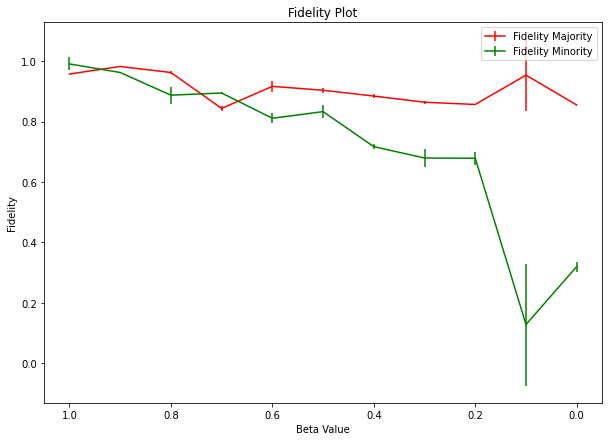

In [31]:
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, 1-mean_fidel_maj, yerr = y_err_fidel_maj, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, 1-mean_fidel_min, yerr = y_err_fidel_min, label = 'Fidelity Minority', color = "green")
plt.xlabel("Beta Value")
plt.ylabel("Fidelity")
plt.xlim(1.05, -0.05)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('with_intervention.jpg')
plt.show()

# Exploration

## Different Base Rates

In [194]:
def diff_base_rates(classifier, X_true, y_true, df_train,
                           sensitive_feature = "cat",
                           apply_fairness = False, verbose = False, num_iters = 10):
    
    total_fidel_maj = []
    total_fidel_min = []
    
    vals = [-4, -1.7, -1.1, -0.7, -0.3, 0, 0.35, 0.7, 1.15, 1.75, 4]
    bias_amts = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5]
    
    for i in range(num_iters):
        fidel_maj = []
        fidel_min = []
        beta = 0.8
        count = 0
        
        for diff in vals:
            arr = np.ones(3)*diff
            outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=n, maj_means = arr)
            
            df_train = df_synthetic.loc[range(0,int(n/2)), :]
            if (n % 2 == 1):
                df_test = df_synthetic.loc[range(int(n/2)+1, n), :]
            else:
                df_test = df_synthetic.loc[range(int(n/2), n), :]

            #df_test_transf = df_test
            df_test_transf, maj_list, min_list = transform(df_test, True)

            df_test_maj = df_test_transf.loc[maj_list]
            df_test_min = df_test_transf.loc[min_list]

            df_fidel_transf, maj_list, min_list = transform(df_fidel, True)

            df_fidel_maj = df_fidel_transf.loc[maj_list]
            df_fidel_min = df_fidel_transf.loc[min_list]

            outcome_cts_maj = outcome_cts.take([maj_list]).flatten()
            outcome_cts_min = outcome_cts.take([min_list]).flatten()

            # format data
            X_true = df_test_transf.iloc[:, :-1].values
            y_true = df_test_transf.iloc[:, -1].values
            X_true_maj = df_test_maj.iloc[:, :-1].values
            y_true_maj = df_test_maj.iloc[:, -1].values
            X_true_min = df_test_min.iloc[:, :-1].values
            y_true_min = df_test_min.iloc[:, -1].values

            df_train_copy = df_train.copy()

            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]

            # unfavored group with negative label
            df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

            # unfavored group with positive label (preferred)
            df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

            # data frame without positively labeled examples from minority class
            df_total = pd.concat([df_majority, df_minority_negative])

            # under-sampling process
            df_undersampled = under_sample(df_minority_positive, beta)

            # combine undersampled and original favored class to create dataset
            df_concat = pd.concat([df_total,df_undersampled])

            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)
            classifier_bias = classifier.fit(X_bias_true, y_bias_true)

            # bayes optimal
            classifier_b_maj = clone(classifier).fit(X_true_maj, y_true_maj)
            classifier_b_min = clone(classifier).fit(X_true_min, y_true_min)    

            classifier_mitigated_bias = GridSearch(clone(classifier_bias), EqualizedOdds())
            classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)

            X_fidel_maj = df_fidel_maj.iloc[:, :-1].values
            pred_maj = pd.DataFrame(classifier_mitigated_bias.predict(X_fidel_maj))
            pred_maj_bo = pd.DataFrame(classifier_b_maj.predict(X_fidel_maj))
            fidel_maj += [(abs(pred_maj.iloc[:, :].values - pred_maj_bo.iloc[:, :].values)).sum() / len(df_fidel_maj)]
            #print('huh', fidel_maj)

            X_fidel_min = df_fidel_min.iloc[:, :-1].values
            pred_min = pd.DataFrame(classifier_mitigated_bias.predict(X_fidel_min))
            pred_min_bo = pd.DataFrame(classifier_b_min.predict(X_fidel_min))
            fidel_min += [(abs(pred_min.iloc[:, :].values - pred_min_bo.iloc[:, :].values)).sum() / len(df_fidel_min)]

            if verbose:
                #print("Finished Iteration: ", count)
                count +=1

        total_fidel_maj.append(fidel_maj)
        total_fidel_min.append(fidel_min)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
   
    mean_fidel_maj = np.mean(total_fidel_maj, axis = 0)
    mean_fidel_min = np.mean(total_fidel_min, axis = 0) 
    
    y_err_fidel_maj = np.std(total_fidel_maj, axis = 0)
    y_err_fidel_min = np.std(total_fidel_min, axis = 0)
   
    return bias_amts, mean_fidel_maj, mean_fidel_min, y_err_fidel_maj, y_err_fidel_min

In [195]:
np.random.seed(42)

classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'l2')

effect_param_maj = [-0.7, 0.5, 1.5]
effect_param_min = [0.5, -0.2, 0.1]

eta = 0.2
n = 30000

bias_amts, mean_fidel_maj1, mean_fidel_min1, y_err_fidel_maj1, y_err_fidel_min1 = \
diff_base_rates(classifier, X_true=X_true, y_true=y_true, \
                       df_train=df_train, sensitive_feature="cat", \
                       apply_fairness=True,verbose=True, num_iters=10)

Diff:  -0.49489999999999995
Diff:  -0.39205
Diff:  -0.2929
Diff:  -0.19415
Diff:  -0.08234999999999998
Diff:  0.0048000000000000265
Diff:  0.10400000000000004
Diff:  0.20344999999999996
Diff:  0.31129999999999997
Diff:  0.41135000000000005
Diff:  0.50455
Finished Total Iteration:  1
Diff:  -0.4931
Diff:  -0.39205
Diff:  -0.2929
Diff:  -0.19415
Diff:  -0.08234999999999998
Diff:  0.0048000000000000265
Diff:  0.10400000000000004
Diff:  0.20344999999999996
Diff:  0.31129999999999997
Diff:  0.41135000000000005
Diff:  0.50455
Finished Total Iteration:  2
Diff:  -0.4931
Diff:  -0.39205
Diff:  -0.2929
Diff:  -0.19415
Diff:  -0.08234999999999998
Diff:  0.0048000000000000265
Diff:  0.10400000000000004
Diff:  0.20344999999999996
Diff:  0.31129999999999997
Diff:  0.41135000000000005
Diff:  0.50455
Finished Total Iteration:  3
Diff:  -0.4931
Diff:  -0.39205
Diff:  -0.2929
Diff:  -0.19415
Diff:  -0.08234999999999998
Diff:  0.0048000000000000265
Diff:  0.10400000000000004
Diff:  0.20344999999999996
D

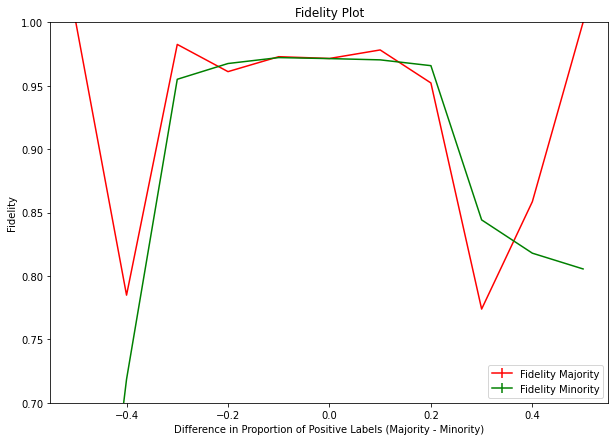

In [196]:
bias_amts = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5]
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, 1-mean_fidel_maj1, yerr = y_err_fidel_maj1, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, 1-mean_fidel_min1, yerr = y_err_fidel_min1, label = 'Fidelity Minority', color = "green")
plt.xlabel("Difference in Proportion of Positive Labels (Majority - Minority)")
plt.ylabel("Fidelity")
plt.ylim(0.7, 1)
#plt.xlim(1.05, -0.05)
plt.legend()
plt.title("Fidelity Plot")
plt.show()

## Representation

In [197]:
def under(df, beta):
    X_min = df.iloc[:, :].values
    
    # keep each example with probability beta
    num_dropped = 0
    random.seed(42)
    for i in range(len(X_min)):
        if random.uniform(0,1) > beta:
            X_min = np.delete(X_min, 0, axis=0)
            num_dropped += 1
    print("Total Deleted: ", num_dropped, "\t % Deleted: ", num_dropped / len(df))
    df = pd.DataFrame(pd.DataFrame(X_min))
    df.columns = ['num1','num2','num3','cat','outcome']
    return df

In [198]:
# if verbose, shows "Finished iteration: ... "
def representation(classifier, X_true, y_true, df_train,
                           sensitive_feature = "cat",
                           apply_fairness = False, verbose = False, num_iters = 10, val = True, inter = False):
    total_fidel_maj = []
    total_fidel_min = []
    
    vals = [-5, -1.7, -1.1, -0.7, -0.3, 0, 0.35, 0.7, 1.15, 1.75, 5]
    #bias_amts = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5]
    
    for i in range(num_iters):
    
        # 1 to 0 in increments of 0.1
        bias_amts = np.divide(list(range(10,-1,-1)),10)
        bias_amts[-1] = 0.01
        #bias_amts = np.divide(list(range(1,11,1)),20)
        
        fidel_maj = []
        fidel_min = []

        count = 0
        
        if val: 
            outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=n)        
        else: outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=n, maj_means =[0.7,0.7,0.7])
        
        # split into train and test
        df_train = df_synthetic.loc[range(0,int(n/2)), :]
        # if original dataset has odd number of samples, remove 1 sample to be even
        if (n % 2 == 1):
            df_test = df_synthetic.loc[range(int(n/2)+1, n), :]
        else:
            df_test = df_synthetic.loc[range(int(n/2), n), :]
        
        #df_test_transf = df_test
        df_test_transf, maj_list, min_list = transform(df_test, True)
            
        df_test_maj = df_test_transf.loc[maj_list]
        df_test_min = df_test_transf.loc[min_list]
        
        df_fidel_transf, maj_list, min_list = transform(df_fidel, True)
        
        df_fidel_maj = df_fidel_transf.loc[maj_list]
        df_fidel_min = df_fidel_transf.loc[min_list]

        outcome_cts_maj = outcome_cts.take([maj_list]).flatten()
        outcome_cts_min = outcome_cts.take([min_list]).flatten()

        # format data
        X_true = df_test_transf.iloc[:, :-1].values
        y_true = df_test_transf.iloc[:, -1].values
        X_true_maj = df_test_maj.iloc[:, :-1].values
        y_true_maj = df_test_maj.iloc[:, -1].values
        X_true_min = df_test_min.iloc[:, :-1].values
        y_true_min = df_test_min.iloc[:, -1].values
        
        # bayes optimal classifier(s) accuracy on ground truth data

        sens_attrs_true = [df_test['cat']]

        for beta in bias_amts:

            if i == 0: print("Beta: ", beta, '\n')

            df_train_copy = df_train.copy()
            
            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]

            if inter:
                # unfavored group with negative label
                df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

                # unfavored group with positive label (preferred)
                df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

                # data frame without positively labeled examples from minority class
                df_total = pd.concat([df_majority, df_minority_negative])

                df_undersampled = under(df_minority_positive, beta)

                # combine undersampled and original favored class to create dataset
                df_concat = pd.concat([df_total,df_undersampled]).sample(frac=1) # permute data

            else:
                df_undersampled = under(df_minority, beta)

                # combine undersampled and original favored class to create dataset
                df_concat = pd.concat([df_majority,df_undersampled])

                df_concat.sample(frac=1) # permute data

            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)
            #X_bias_true, y_bias_true, df_sens = df_concat.iloc[:, :-1].values, df_concat.iloc[:, -1].values, df_concat['cat']

            classifier_bias = classifier.fit(X_bias_true, y_bias_true)
            #if i == 0: print("Model + No Intervention Coefs: ", classifier_bias.coef_)
            
            # bayes optimal
            classifier_b = clone(classifier).fit(X_true, y_true)
            bo_pred = classifier_b.predict(X_true)
            
            classifier_b_maj = clone(classifier).fit(X_true_maj, y_true_maj)
            bo_maj_pred = classifier_b_maj.predict(X_true_maj)
            
            classifier_b_min = clone(classifier).fit(X_true_min, y_true_min)
            bo_min_pred = classifier_b_min.predict(X_true_min)

            if apply_fairness:
                constraint = EqualizedOdds()
                classifier_mitigated_bias = GridSearch(clone(classifier_bias), constraint)
                #classifier_mitigated_bias = ExponentiatedGradient(clone(classifier_bias), constraint)
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)

                # testing on biased data WITH fairness intervention
                y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)

                # testing on GT data WITH fairness intervention
                y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
                y_pred_mitigated_bias_on_true_maj = classifier_mitigated_bias.predict(X_true_maj)
                y_pred_mitigated_bias_on_true_min = classifier_mitigated_bias.predict(X_true_min)
            
            # fidelity check
            
            X_fidel_maj = df_fidel_maj.iloc[:, :-1].values
            pred_maj = pd.DataFrame(classifier_mitigated_bias.predict(X_fidel_maj))
            pred_maj_bo = pd.DataFrame(classifier_b_maj.predict(X_fidel_maj))
            fidel_maj += [(abs(pred_maj.iloc[:, :].values - pred_maj_bo.iloc[:, :].values)).sum() / len(df_fidel_maj)]
            
            
            X_fidel_min = df_fidel_min.iloc[:, :-1].values
            pred_min = pd.DataFrame(classifier_mitigated_bias.predict(X_fidel_min))
            pred_min_bo = pd.DataFrame(classifier_b_min.predict(X_fidel_min))
            fidel_min += [(abs(pred_min.iloc[:, :].values - pred_min_bo.iloc[:, :].values)).sum() / len(df_fidel_min)]
               
                        
            #break
                
            if verbose:
                #print("Finished Iteration: ", count)
                count +=1
        
        total_fidel_maj.append(fidel_maj)
        total_fidel_min.append(fidel_min)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
    
    mean_fidel_maj = np.mean(total_fidel_maj, axis = 0)
    mean_fidel_min = np.mean(total_fidel_min, axis = 0) 
    
    y_err_fidel_maj = np.std(total_fidel_maj, axis = 0)
    y_err_fidel_min = np.std(total_fidel_min, axis = 0)

    return bias_amts, mean_fidel_maj, mean_fidel_min, y_err_fidel_maj, y_err_fidel_min

In [199]:
np.random.seed(42)

classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'l2')

effect_param_maj = [-0.7, 0.5, 1.5]
effect_param_min = [0.5, -0.2, 0.1]

eta = 0.2
n = 30000

bias_amts, mean_fidel_maj2, mean_fidel_min2, y_err_fidel_maj2, y_err_fidel_min2 = \
representation(classifier, X_true=X_true, y_true=y_true, \
                       df_train=df_train, sensitive_feature="cat", \
                       apply_fairness=True,verbose=True, num_iters=10)

Diff:  0.008299999999999974
Beta:  1.0 

Total Deleted:  0 	 % Deleted:  0.0
Beta:  0.9 

Total Deleted:  486 	 % Deleted:  0.0967741935483871
Beta:  0.8 

Total Deleted:  983 	 % Deleted:  0.19573874950219036
Beta:  0.7 

Total Deleted:  1480 	 % Deleted:  0.2947033054559936
Beta:  0.6 

Total Deleted:  2022 	 % Deleted:  0.4026284348864994
Beta:  0.5 

Total Deleted:  2540 	 % Deleted:  0.5057745917960972
Beta:  0.4 

Total Deleted:  3018 	 % Deleted:  0.6009557945041816
Beta:  0.3 

Total Deleted:  3523 	 % Deleted:  0.7015133412982876
Beta:  0.2 

Total Deleted:  4030 	 % Deleted:  0.8024691358024691
Beta:  0.1 

Total Deleted:  4540 	 % Deleted:  0.9040223018717642
Beta:  0.01 

Total Deleted:  4966 	 % Deleted:  0.9888490641178813
Finished Total Iteration:  1
Diff:  -0.00039999999999995595
Total Deleted:  0 	 % Deleted:  0.0
Total Deleted:  486 	 % Deleted:  0.0967741935483871
Total Deleted:  983 	 % Deleted:  0.19573874950219036
Total Deleted:  1480 	 % Deleted:  0.2947033054559

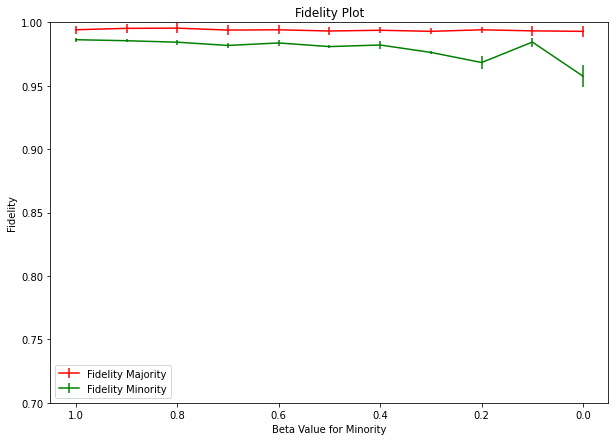

In [200]:
bias_amts = np.divide(list(range(10,-1,-1)),10)
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, 1-mean_fidel_maj2, yerr = y_err_fidel_maj2, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, 1-mean_fidel_min2, yerr = y_err_fidel_min2, label = 'Fidelity Minority', color = "green")
plt.xlabel("Beta Value for Minority")
plt.ylabel("Fidelity")
plt.xlim(1.05, -0.05)
plt.ylim(0.7, 1)
# plt.ylim(0.95, 1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('rep_without.jpg')
plt.show()

### Intersectional

In [201]:
# diff base rates
np.random.seed(42)
classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'l2')

effect_param_maj = [-0.7, 0.5, 1.5]
effect_param_min = [0.5, -0.2, 0.1]

eta = 0.2
n = 30000

bias_amts, mean_fidel_maj10, mean_fidel_min10, y_err_fidel_maj10, y_err_fidel_min10 = \
representation(classifier, X_true=X_true, y_true=y_true, \
                       df_train=df_train, sensitive_feature="cat", \
                       apply_fairness=True,verbose=True, num_iters=10, val = False, inter = True)

Diff:  0.20750000000000002
Beta:  1.0 

Total Deleted:  0 	 % Deleted:  0.0
Beta:  0.9 

Total Deleted:  251 	 % Deleted:  0.10044017607042817
Beta:  0.8 

Total Deleted:  500 	 % Deleted:  0.2000800320128051
Beta:  0.7 

Total Deleted:  750 	 % Deleted:  0.30012004801920766
Beta:  0.6 

Total Deleted:  1016 	 % Deleted:  0.40656262505002
Beta:  0.5 

Total Deleted:  1278 	 % Deleted:  0.5114045618247299
Beta:  0.4 

Total Deleted:  1531 	 % Deleted:  0.6126450580232092
Beta:  0.3 

Total Deleted:  1779 	 % Deleted:  0.7118847539015606
Beta:  0.2 

Total Deleted:  2028 	 % Deleted:  0.8115246098439376
Beta:  0.1 

Total Deleted:  2264 	 % Deleted:  0.9059623849539816
Beta:  0.01 

Total Deleted:  2475 	 % Deleted:  0.9903961584633854
Finished Total Iteration:  1
Diff:  0.19804999999999995
Total Deleted:  0 	 % Deleted:  0.0
Total Deleted:  256 	 % Deleted:  0.10015649452269171
Total Deleted:  509 	 % Deleted:  0.1991392801251956
Total Deleted:  764 	 % Deleted:  0.29890453834115804
Tot

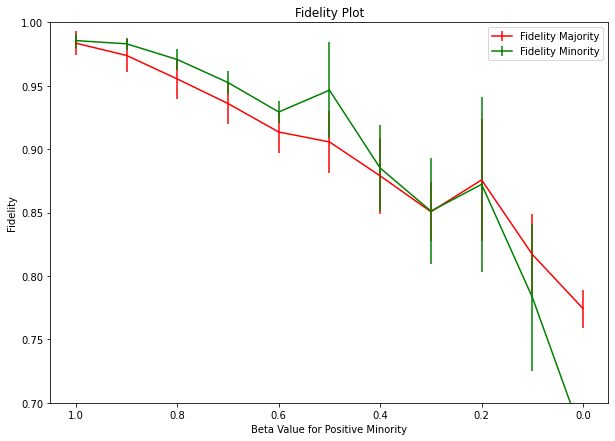

In [202]:
bias_amts = np.divide(list(range(10,-1,-1)),10)
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, 1-mean_fidel_maj10, yerr = y_err_fidel_maj10, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, 1-mean_fidel_min10, yerr = y_err_fidel_min10, label = 'Fidelity Minority', color = "green")
plt.xlabel("Beta Value for Positive Minority")
plt.ylabel("Fidelity")
plt.xlim(1.05, -0.05)
plt.ylim(0.7, 1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('rep_diff.jpg')
plt.show()

### Same Base Rates

In [203]:
np.random.seed(42)
classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'l2')

effect_param_maj = [-0.7, 0.5, 1.5]
effect_param_min = [0.5, -0.2, 0.1]

eta = 0.2
n = 30000

bias_amts, mean_fidel_maj3, mean_fidel_min3, y_err_fidel_maj3, y_err_fidel_min3 = \
representation(classifier, X_true=X_true, y_true=y_true, \
                       df_train=df_train, sensitive_feature="cat", \
                       apply_fairness=True,verbose=True, num_iters=10, inter = True)

Diff:  0.008299999999999974
Beta:  1.0 

Total Deleted:  0 	 % Deleted:  0.0
Beta:  0.9 

Total Deleted:  251 	 % Deleted:  0.10044017607042817
Beta:  0.8 

Total Deleted:  500 	 % Deleted:  0.2000800320128051
Beta:  0.7 

Total Deleted:  750 	 % Deleted:  0.30012004801920766
Beta:  0.6 

Total Deleted:  1016 	 % Deleted:  0.40656262505002
Beta:  0.5 

Total Deleted:  1278 	 % Deleted:  0.5114045618247299
Beta:  0.4 

Total Deleted:  1531 	 % Deleted:  0.6126450580232092
Beta:  0.3 

Total Deleted:  1779 	 % Deleted:  0.7118847539015606
Beta:  0.2 

Total Deleted:  2028 	 % Deleted:  0.8115246098439376
Beta:  0.1 

Total Deleted:  2264 	 % Deleted:  0.9059623849539816
Beta:  0.01 

Total Deleted:  2475 	 % Deleted:  0.9903961584633854
Finished Total Iteration:  1
Diff:  0.0022999999999999687
Total Deleted:  0 	 % Deleted:  0.0
Total Deleted:  256 	 % Deleted:  0.10015649452269171
Total Deleted:  509 	 % Deleted:  0.1991392801251956
Total Deleted:  764 	 % Deleted:  0.29890453834115804


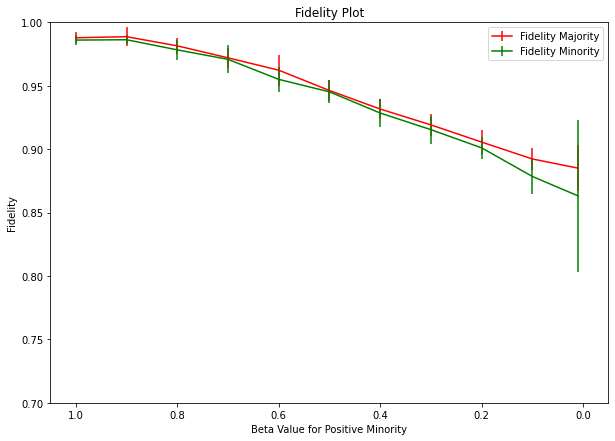

In [204]:
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, 1-mean_fidel_maj3, yerr = y_err_fidel_maj3, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, 1-mean_fidel_min3, yerr = y_err_fidel_min3, label = 'Fidelity Minority', color = "green")
plt.xlabel("Beta Value for Positive Minority")
plt.ylabel("Fidelity")
plt.xlim(1.05, -0.05)
plt.ylim(0.7, 1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('rep_inter.jpg')
plt.show()

## Label Noise

In [16]:
def flip(df_synthetic, eta):
    labels = df_synthetic['outcome'].values
    #print('Before:', df_synthetic['outcome'].value_counts())
    num_flipped = 0
    random.seed(42)
    for i in range(len(labels)):
        if random.uniform(0,1) <= eta:
            labels[i] = 1 if labels[i] == 0 else 0
            num_flipped += 1
    df_synthetic['outcome'] = labels
    #print('After:', df_synthetic['outcome'].value_counts())
    print('Bias Num Flipped: ', num_flipped, "\tRate: ", num_flipped / len(df_synthetic))
    return df_synthetic

def get_noise(df, beta, inter = False):
    df_majority = df[df['cat'] == 1]
    df_minority = df[df['cat'] == 0]
    
    if inter:
        # unfavored group with negative label
        df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

        # unfavored group with positive label (preferred)
        df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

        # data frame without positively labeled examples from minority class
        df_total = pd.concat([df_majority, df_minority_negative])
        
        df_undersampled = flip(df_minority_positive, beta)

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_total,df_undersampled])

        return df_concat.sample(frac=1, random_state = 42) # permute data
    
    else:
        df_undersampled = flip(df_minority, beta)

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_majority,df_undersampled])

        return df_concat.sample(frac=1, random_state = 42) # permute data

In [19]:
# if verbose, shows "Finished iteration: ... "
def label_noise(classifier, X_true, y_true, df_train,
                           sensitive_feature = "cat",
                           apply_fairness = False, verbose = False, num_iters = 10, val = True, inter = False):
    total_fidel_maj = []
    total_fidel_min = []
    
    vals = [-5, -1.7, -1.1, -0.7, -0.3, 0, 0.35, 0.7, 1.15, 1.75, 5]
    #bias_amts = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5]
    
    for i in range(num_iters):
    
        # 1 to 0 in increments of 0.1
        #bias_amts = np.divide(list(range(1,11,1)),10)
        #bias_amts = np.divide(list(range(1,11,1)),20)
        bias_amts = np.divide(list(range(1,11,1)),22)
        
        
        fidel_maj = []
        fidel_min = []

        count = 0
        
        eta = 0 # delete later!
        
        if val: 
            outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=n)        
        else: outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=n, maj_means =[0.7,0.7,0.7])
        
        # split into train and test
        df_train = df_synthetic.loc[range(0,int(n/2)), :]
        # if original dataset has odd number of samples, remove 1 sample to be even
        if (n % 2 == 1):
            df_test = df_synthetic.loc[range(int(n/2)+1, n), :]
        else:
            df_test = df_synthetic.loc[range(int(n/2), n), :]
        
        #df_test_transf = df_test
        df_test_transf, maj_list, min_list = transform(df_test, True)
            
        df_test_maj = df_test_transf.loc[maj_list]
        df_test_min = df_test_transf.loc[min_list]
        
        df_fidel_transf, maj_list, min_list = transform(df_fidel, True)
        
        df_fidel_maj = df_fidel_transf.loc[maj_list]
        df_fidel_min = df_fidel_transf.loc[min_list]

        outcome_cts_maj = outcome_cts.take([maj_list]).flatten()
        outcome_cts_min = outcome_cts.take([min_list]).flatten()

        # format data
        X_true = df_test_transf.iloc[:, :-1].values
        y_true = df_test_transf.iloc[:, -1].values
        X_true_maj = df_test_maj.iloc[:, :-1].values
        y_true_maj = df_test_maj.iloc[:, -1].values
        X_true_min = df_test_min.iloc[:, :-1].values
        y_true_min = df_test_min.iloc[:, -1].values
        
        # bayes optimal classifier(s) accuracy on ground truth data

        sens_attrs_true = [df_test['cat']]

        for beta in bias_amts:
            
            if i == 0: print("Beta: ", beta, '\n')

            df_train_copy = df_train.copy()

            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]

            # unfavored group with negative label
            df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

            # unfavored group with positive label (preferred)
            df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

            # data frame without positively labeled examples from minority class
            df_total = pd.concat([df_majority, df_minority_negative])

            # under-sampling process
            df_undersampled = under_sample(df_minority_positive, 1)
            #df_undersampled = under_sample(df_minority, beta)

            # combine undersampled and original favored class to create dataset
            df_concat1 = pd.concat([df_total,df_undersampled])
            
            df_concat = get_noise(df_concat1, beta, inter) # group-dependent label noise

            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)
            #X_bias_true, y_bias_true, df_sens = df_concat.iloc[:, :-1].values, df_concat.iloc[:, -1].values, df_concat['cat']

            classifier_bias = classifier.fit(X_bias_true, y_bias_true)
            #if i == 0: print("Model + No Intervention Coefs: ", classifier_bias.coef_)
            
            # bayes optimal
            classifier_b = clone(classifier).fit(X_true, y_true)
            bo_pred = classifier_b.predict(X_true)
            
            classifier_b_maj = clone(classifier).fit(X_true_maj, y_true_maj)
            bo_maj_pred = classifier_b_maj.predict(X_true_maj)
            
            classifier_b_min = clone(classifier).fit(X_true_min, y_true_min)
            bo_min_pred = classifier_b_min.predict(X_true_min)

            if apply_fairness:
                constraint = EqualizedOdds()
                classifier_mitigated_bias = GridSearch(clone(classifier_bias), constraint)
                #classifier_mitigated_bias = ExponentiatedGradient(clone(classifier_bias), constraint)
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)

                # testing on biased data WITH fairness intervention
                y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)

                # testing on GT data WITH fairness intervention
                y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
                y_pred_mitigated_bias_on_true_maj = classifier_mitigated_bias.predict(X_true_maj)
                y_pred_mitigated_bias_on_true_min = classifier_mitigated_bias.predict(X_true_min)
            
            # fidelity check
            
            X_fidel_maj = df_fidel_maj.iloc[:, :-1].values
            pred_maj = pd.DataFrame(classifier_mitigated_bias.predict(X_fidel_maj))
            pred_maj_bo = pd.DataFrame(classifier_b_maj.predict(X_fidel_maj))
            fidel_maj += [(abs(pred_maj.iloc[:, :].values - pred_maj_bo.iloc[:, :].values)).sum() / len(df_fidel_maj)]
            
            
            X_fidel_min = df_fidel_min.iloc[:, :-1].values
            pred_min = pd.DataFrame(classifier_mitigated_bias.predict(X_fidel_min))
            pred_min_bo = pd.DataFrame(classifier_b_min.predict(X_fidel_min))
            fidel_min += [(abs(pred_min.iloc[:, :].values - pred_min_bo.iloc[:, :].values)).sum() / len(df_fidel_min)]
               
                        
            #break
                
            if verbose:
                print("Finished Iteration: ", count)
                count +=1

            # fail-safe
            if count > 30:
                break
        
        total_fidel_maj.append(fidel_maj)
        total_fidel_min.append(fidel_min)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
    
    mean_fidel_maj = np.mean(total_fidel_maj, axis = 0)
    mean_fidel_min = np.mean(total_fidel_min, axis = 0) 
    
    y_err_fidel_maj = np.std(total_fidel_maj, axis = 0)
    y_err_fidel_min = np.std(total_fidel_min, axis = 0)

    return bias_amts, mean_fidel_maj, mean_fidel_min, y_err_fidel_maj, y_err_fidel_min

In [20]:
np.random.seed(42)
classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'l2')

effect_param_maj = [-0.7, 0.5, 1.5]
effect_param_min = [0.5, -0.2, 0.1]

eta = 0.2
n = 30000

bias_amts, mean_fidel_maj4, mean_fidel_min4, y_err_fidel_maj4, y_err_fidel_min4 = \
label_noise(classifier, X_true=X_true, y_true=y_true, \
                       df_train=df_train, sensitive_feature="cat", \
                       apply_fairness=True,verbose=True, num_iters=10)

Diff:  0.008299999999999974
Num Flipped Maj:  4067 	Rate:  0.20335
Num Flipped Min:  0 	Rate:  0.0
Beta:  0.045454545454545456 

Bias Num Flipped:  209 	Rate:  0.04161688570290721
Finished Iteration:  0
Beta:  0.09090909090909091 

Bias Num Flipped:  428 	Rate:  0.08522500995619275
Finished Iteration:  1
Beta:  0.13636363636363635 

Bias Num Flipped:  671 	Rate:  0.1336121067303863
Finished Iteration:  2
Beta:  0.18181818181818182 

Bias Num Flipped:  909 	Rate:  0.18100358422939067
Finished Iteration:  3
Beta:  0.22727272727272727 

Bias Num Flipped:  1119 	Rate:  0.22281959378733573
Finished Iteration:  4
Beta:  0.2727272727272727 

Bias Num Flipped:  1357 	Rate:  0.2702110712863401
Finished Iteration:  5
Beta:  0.3181818181818182 

Bias Num Flipped:  1610 	Rate:  0.320589406610912
Finished Iteration:  6
Beta:  0.36363636363636365 

Bias Num Flipped:  1819 	Rate:  0.3622062923138192
Finished Iteration:  7
Beta:  0.4090909090909091 

Bias Num Flipped:  2039 	Rate:  0.40601354042214255

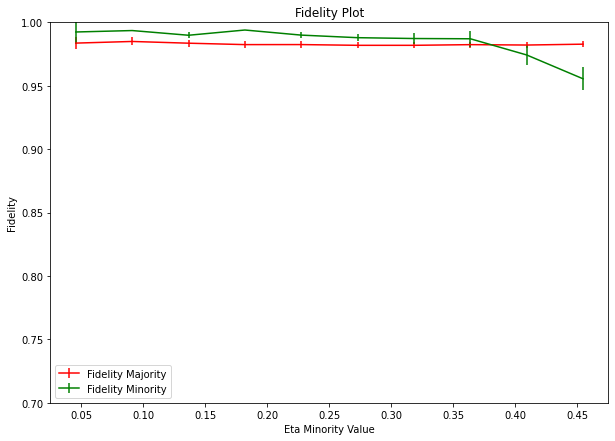

In [21]:
bias_amts = np.divide(list(range(1,11,1)),22)
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, 1-mean_fidel_maj4, yerr = y_err_fidel_maj4, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, 1-mean_fidel_min4, yerr = y_err_fidel_min4, label = 'Fidelity Minority', color = "green")
plt.xlabel("Eta Minority Value")
plt.ylabel("Fidelity")
plt.ylim(0.7,1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('labelnoise_without.jpg')
plt.show()

## Intersectional (Positive Minority Flipped)

In [22]:
# Below is for diff base rates

In [23]:
np.random.seed(42)
classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'l2')

effect_param_maj = [-0.7, 0.5, 1.5]
effect_param_min = [0.5, -0.2, 0.1]

eta = 0.2
n = 30000

bias_amts, mean_fidel_maj11, mean_fidel_min11, y_err_fidel_maj11, y_err_fidel_min11 = \
label_noise(classifier, X_true=X_true, y_true=y_true, \
                       df_train=df_train, sensitive_feature="cat", \
                       apply_fairness=True,verbose=True, num_iters=10, val = False, inter = True)

Diff:  0.20750000000000002
Num Flipped Maj:  4067 	Rate:  0.20335
Num Flipped Min:  0 	Rate:  0.0
Beta:  0.045454545454545456 

Bias Num Flipped:  97 	Rate:  0.03917609046849758
Finished Iteration:  0
Beta:  0.09090909090909091 

Bias Num Flipped:  206 	Rate:  0.08319870759289176
Finished Iteration:  1
Beta:  0.13636363636363635 

Bias Num Flipped:  321 	Rate:  0.12964458804523424
Finished Iteration:  2
Beta:  0.18181818181818182 

Bias Num Flipped:  430 	Rate:  0.17366720516962844
Finished Iteration:  3
Beta:  0.22727272727272727 

Bias Num Flipped:  532 	Rate:  0.2148626817447496
Finished Iteration:  4
Beta:  0.2727272727272727 

Bias Num Flipped:  642 	Rate:  0.2592891760904685
Finished Iteration:  5
Beta:  0.3181818181818182 

Bias Num Flipped:  766 	Rate:  0.30936995153473346
Finished Iteration:  6
Beta:  0.36363636363636365 

Bias Num Flipped:  876 	Rate:  0.35379644588045234
Finished Iteration:  7
Beta:  0.4090909090909091 

Bias Num Flipped:  980 	Rate:  0.39579967689822293
Fin

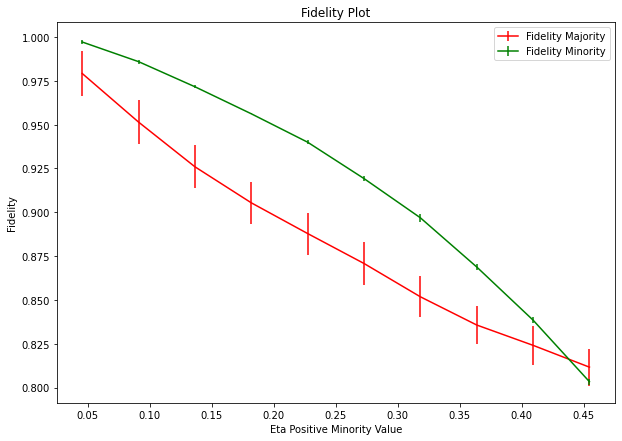

In [24]:
bias_amts = np.divide(list(range(1,11,1)),22)
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, 1-mean_fidel_maj11, yerr = y_err_fidel_maj11, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, 1-mean_fidel_min11, yerr = y_err_fidel_min11, label = 'Fidelity Minority', color = "green")
plt.xlabel("Eta Positive Minority Value")
plt.ylabel("Fidelity")
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('labelnoise_diff.jpg')
plt.show()

### Same Base Rates

In [25]:
np.random.seed(42)
classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'l2')

effect_param_maj = [-0.7, 0.5, 1.5]
effect_param_min = [0.5, -0.2, 0.1]

eta = 0.2
n = 30000

bias_amts, mean_fidel_maj5, mean_fidel_min5, y_err_fidel_maj5, y_err_fidel_min5 = \
label_noise(classifier, X_true=X_true, y_true=y_true, \
                       df_train=df_train, sensitive_feature="cat", \
                       apply_fairness=True,verbose=True, num_iters=10, inter = True)

Diff:  0.008299999999999974
Num Flipped Maj:  4067 	Rate:  0.20335
Num Flipped Min:  0 	Rate:  0.0
Beta:  0.045454545454545456 

Bias Num Flipped:  97 	Rate:  0.03917609046849758
Finished Iteration:  0
Beta:  0.09090909090909091 

Bias Num Flipped:  206 	Rate:  0.08319870759289176
Finished Iteration:  1
Beta:  0.13636363636363635 

Bias Num Flipped:  321 	Rate:  0.12964458804523424
Finished Iteration:  2
Beta:  0.18181818181818182 

Bias Num Flipped:  430 	Rate:  0.17366720516962844
Finished Iteration:  3
Beta:  0.22727272727272727 

Bias Num Flipped:  532 	Rate:  0.2148626817447496
Finished Iteration:  4
Beta:  0.2727272727272727 

Bias Num Flipped:  642 	Rate:  0.2592891760904685
Finished Iteration:  5
Beta:  0.3181818181818182 

Bias Num Flipped:  766 	Rate:  0.30936995153473346
Finished Iteration:  6
Beta:  0.36363636363636365 

Bias Num Flipped:  876 	Rate:  0.35379644588045234
Finished Iteration:  7
Beta:  0.4090909090909091 

Bias Num Flipped:  980 	Rate:  0.39579967689822293
Fi

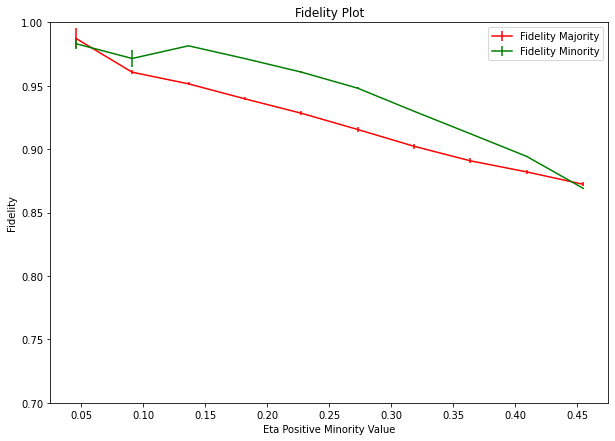

In [26]:
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, 1-mean_fidel_maj5, yerr = y_err_fidel_maj5, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, 1-mean_fidel_min5, yerr = y_err_fidel_min5, label = 'Fidelity Minority', color = "green")
plt.xlabel("Eta Positive Minority Value")
plt.ylabel("Fidelity")
plt.ylim(0.7,1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('labelnoise_inter.jpg')
plt.show()

## Feature Noise/Missingness

In [214]:
# def inject_noise_num(df, feature, eps = 1):
#     for i in range(len(df[feature])):
#         df[feature].iloc[i] = 0 # zero out feature
# #         df[feature].iloc[i] += np.random.normal(0, 1) * eps # standard normal

#     return df

def inject_noise_num(df, feature, eta, eps = 1):
    feats = df[feature].values
    #print('Before:', df_synthetic['outcome'].value_counts())
    num_flipped = 0
    random.seed(42)
    for i in range(len(feats)):
        if random.uniform(0,1) <= eta:
            feats[i] = 0
            num_flipped += 1
    df[feature] = feats
    print('Num Flipped: ', num_flipped, "\tRate: ", num_flipped / len(df))
    return df

# measurement bias
def get_biased_data(df, eps, inter):
    df_majority = df[df['cat'] == 1]
    df_minority = df[df['cat'] == 0]
    
    if inter:
    
        # unfavored group with negative label
        df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

        # unfavored group with positive label (preferred)
        df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

        # data frame without positively labeled examples from minority class
        df_total = pd.concat([df_majority, df_minority_negative])

        # under-sampling process
        df_bias = inject_noise_num(df_minority_positive, 'num1', eps)

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_total,df_bias])
    
    else:
        # under-sampling process
        df_bias = inject_noise_num(df_minority, 'num1', eps)
        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_majority,df_bias])
    
    return df_concat.sample(frac=1, random_state = 42) # permute data

In [215]:
# if verbose, shows "Finished iteration: ... "
def measurement(classifier, X_true, y_true, df_train,
                           sensitive_feature = "cat",
                           apply_fairness = False, verbose = False, num_iters = 10, val = True, inter = False):
    total_fidel_maj = []
    total_fidel_min = []
    
    vals = [-5, -1.7, -1.1, -0.7, -0.3, 0, 0.35, 0.7, 1.15, 1.75, 5]
    #bias_amts = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5]
    
    for i in range(num_iters):
    
        # 1 to 0 in increments of 0.1
        bias_amts = np.divide(list(range(0,11,1)),10)
        bias_amts[0] = 0.01 # doesn't work with 0
        
        fidel_maj = []
        fidel_min = []

        count = 0
        
        if val: outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=n)        
        else: outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=n, maj_means =[0.7,0.7,0.7])
        
        # split into train and test
        df_train = df_synthetic.loc[range(0,int(n/2)), :]
        # if original dataset has odd number of samples, remove 1 sample to be even
        if (n % 2 == 1):
            df_test = df_synthetic.loc[range(int(n/2)+1, n), :]
        else:
            df_test = df_synthetic.loc[range(int(n/2), n), :]
        
        #df_test_transf = df_test
        df_test_transf, maj_list, min_list = transform(df_test, True)
            
        df_test_maj = df_test_transf.loc[maj_list]
        df_test_min = df_test_transf.loc[min_list]
        
        df_fidel_transf, maj_list, min_list = transform(df_fidel, True)
        
        df_fidel_maj = df_fidel_transf.loc[maj_list]
        df_fidel_min = df_fidel_transf.loc[min_list]

        outcome_cts_maj = outcome_cts.take([maj_list]).flatten()
        outcome_cts_min = outcome_cts.take([min_list]).flatten()

        # format data
        X_true = df_test_transf.iloc[:, :-1].values
        y_true = df_test_transf.iloc[:, -1].values
        X_true_maj = df_test_maj.iloc[:, :-1].values
        y_true_maj = df_test_maj.iloc[:, -1].values
        X_true_min = df_test_min.iloc[:, :-1].values
        y_true_min = df_test_min.iloc[:, -1].values
        
        # bayes optimal classifier(s) accuracy on ground truth data

        sens_attrs_true = [df_test['cat']]

        for beta in bias_amts:
            
            if i == 0: print("Beta: ", beta, '\n')

            df_train_copy = df_train.copy()

            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]

            # unfavored group with negative label
            df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

            # unfavored group with positive label (preferred)
            df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

            # data frame without positively labeled examples from minority class
            df_total = pd.concat([df_majority, df_minority_negative])

            # under-sampling process
            df_undersampled = under_sample(df_minority_positive, 1)
            
            # combine undersampled and original favored class to create dataset
            df_concat1 = pd.concat([df_total,df_undersampled])
            
            df_minority = df_concat1[df_concat1['cat'] == 0]
            
            # make sure we properly zero'd out num1
            #df_pos = df_minority[df_minority['outcome'] == 1]
            #if beta == 1: print('Before', get_summary_num(df_pos, 'num1'))
            
            df_concat = get_biased_data(df_concat1, beta, inter)
            #df_minority2 = df_concat[df_concat['cat'] == 0]
            
            # make sure we properly zero'd out num1
            #df_pos = df_minority2[df_minority2['outcome'] == 1]
            #if beta == 1: print('After ', get_summary_num(df_pos, 'num1'))

            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)
            #X_bias_true, y_bias_true, df_sens = df_concat.iloc[:, :-1].values, df_concat.iloc[:, -1].values, df_concat['cat']

            classifier_bias = classifier.fit(X_bias_true, y_bias_true)
            #if i == 0: print("Model + No Intervention Coefs: ", classifier_bias.coef_)
            
            # bayes optimal
            classifier_b = clone(classifier).fit(X_true, y_true)
            bo_pred = classifier_b.predict(X_true)
            
            classifier_b_maj = clone(classifier).fit(X_true_maj, y_true_maj)
            bo_maj_pred = classifier_b_maj.predict(X_true_maj)
            
            classifier_b_min = clone(classifier).fit(X_true_min, y_true_min)
            bo_min_pred = classifier_b_min.predict(X_true_min)

            if apply_fairness:
                constraint = EqualizedOdds()
                classifier_mitigated_bias = GridSearch(clone(classifier_bias), constraint)
                #classifier_mitigated_bias = ExponentiatedGradient(clone(classifier_bias), constraint)
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)

                # testing on biased data WITH fairness intervention
                y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)

                # testing on GT data WITH fairness intervention
                y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
                y_pred_mitigated_bias_on_true_maj = classifier_mitigated_bias.predict(X_true_maj)
                y_pred_mitigated_bias_on_true_min = classifier_mitigated_bias.predict(X_true_min)
            
            # fidelity check
            
            X_fidel_maj = df_fidel_maj.iloc[:, :-1].values
            pred_maj = pd.DataFrame(classifier_mitigated_bias.predict(X_fidel_maj))
            pred_maj_bo = pd.DataFrame(classifier_b_maj.predict(X_fidel_maj))
            fidel_maj += [(abs(pred_maj.iloc[:, :].values - pred_maj_bo.iloc[:, :].values)).sum() / len(df_fidel_maj)]
            
            
            X_fidel_min = df_fidel_min.iloc[:, :-1].values
            pred_min = pd.DataFrame(classifier_mitigated_bias.predict(X_fidel_min))
            pred_min_bo = pd.DataFrame(classifier_b_min.predict(X_fidel_min))
            fidel_min += [(abs(pred_min.iloc[:, :].values - pred_min_bo.iloc[:, :].values)).sum() / len(df_fidel_min)]
               
                        
            #break
                
            if verbose:
                print("Finished Iteration: ", count)
                count +=1

            # fail-safe
            if count > 30:
                break
        
        total_fidel_maj.append(fidel_maj)
        total_fidel_min.append(fidel_min)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
    
    mean_fidel_maj = np.mean(total_fidel_maj, axis = 0)
    mean_fidel_min = np.mean(total_fidel_min, axis = 0) 
    
    y_err_fidel_maj = np.std(total_fidel_maj, axis = 0)
    y_err_fidel_min = np.std(total_fidel_min, axis = 0)

    return bias_amts, mean_fidel_maj, mean_fidel_min, y_err_fidel_maj, y_err_fidel_min

In [216]:
import warnings
warnings.filterwarnings("ignore")

In [217]:
np.random.seed(42)
classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'l2')

effect_param_maj = [-0.7, 0.5, 1.5]
effect_param_min = [0.5, -0.2, 0.1]

eta = 0.2
n = 30000

bias_amts, mean_fidel_maj6, mean_fidel_min6, y_err_fidel_maj6, y_err_fidel_min6 = \
measurement(classifier, X_true=X_true, y_true=y_true, \
                       df_train=df_train, sensitive_feature="cat", \
                       apply_fairness=True,verbose=True, num_iters=10)

Diff:  0.008299999999999974
Beta:  0.01 

Num Flipped:  56 	Rate:  0.011150935882118677
Finished Iteration:  0
Beta:  0.1 

Num Flipped:  482 	Rate:  0.09597769812823577
Finished Iteration:  1
Beta:  0.2 

Num Flipped:  992 	Rate:  0.19753086419753085
Finished Iteration:  2
Beta:  0.3 

Num Flipped:  1499 	Rate:  0.2984866587017125
Finished Iteration:  3
Beta:  0.4 

Num Flipped:  2004 	Rate:  0.39904420549581837
Finished Iteration:  4
Beta:  0.5 

Num Flipped:  2482 	Rate:  0.4942254082039028
Finished Iteration:  5
Beta:  0.6 

Num Flipped:  3000 	Rate:  0.5973715651135006
Finished Iteration:  6
Beta:  0.7 

Num Flipped:  3542 	Rate:  0.7052966945440063
Finished Iteration:  7
Beta:  0.8 

Num Flipped:  4039 	Rate:  0.8042612504978096
Finished Iteration:  8
Beta:  0.9 

Num Flipped:  4536 	Rate:  0.9032258064516129
Finished Iteration:  9
Beta:  1.0 

Num Flipped:  5022 	Rate:  1.0
Finished Iteration:  10
Finished Total Iteration:  1
Diff:  0.0048000000000000265
Num Flipped:  56 	Rate: 

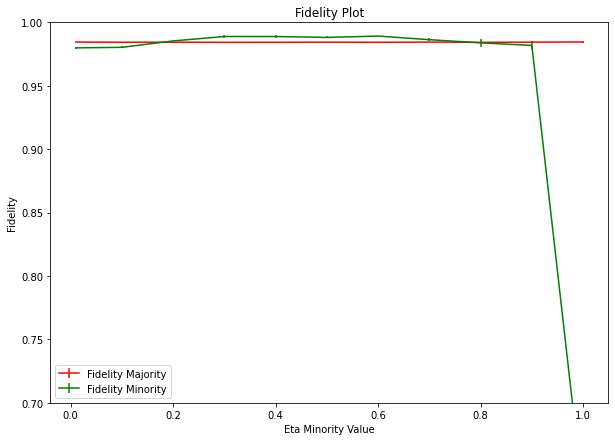

In [218]:
bias_amts = np.divide(list(range(0,11,1)),10)
bias_amts[0] = 0.01 # doesn't work with 0

plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, 1-mean_fidel_maj6, yerr = y_err_fidel_maj6, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, 1-mean_fidel_min6, yerr = y_err_fidel_min6, label = 'Fidelity Minority', color = "green")
plt.xlabel("Eta Minority Value")
plt.ylabel("Fidelity")
plt.ylim(0.7, 1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('featnoise_without.jpg')
plt.show()

## Intersectional

In [219]:
np.random.seed(42)
classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'l2')

effect_param_maj = [-0.7, 0.5, 1.5]
effect_param_min = [0.5, -0.2, 0.1]

eta = 0.2
n = 30000

bias_amts, mean_fidel_maj7, mean_fidel_min7, y_err_fidel_maj7, y_err_fidel_min7 = \
measurement(classifier, X_true=X_true, y_true=y_true, \
                       df_train=df_train, sensitive_feature="cat", \
                       apply_fairness=True,verbose=True, num_iters=10, inter = True)

Diff:  0.008299999999999974
Beta:  0.01 

Num Flipped:  24 	Rate:  0.009603841536614645
Finished Iteration:  0
Beta:  0.1 

Num Flipped:  235 	Rate:  0.0940376150460184
Finished Iteration:  1
Beta:  0.2 

Num Flipped:  471 	Rate:  0.18847539015606243
Finished Iteration:  2
Beta:  0.3 

Num Flipped:  720 	Rate:  0.28811524609843936
Finished Iteration:  3
Beta:  0.4 

Num Flipped:  968 	Rate:  0.3873549419767907
Finished Iteration:  4
Beta:  0.5 

Num Flipped:  1221 	Rate:  0.4885954381752701
Finished Iteration:  5
Beta:  0.6 

Num Flipped:  1483 	Rate:  0.59343737494998
Finished Iteration:  6
Beta:  0.7 

Num Flipped:  1749 	Rate:  0.6998799519807923
Finished Iteration:  7
Beta:  0.8 

Num Flipped:  1999 	Rate:  0.7999199679871949
Finished Iteration:  8
Beta:  0.9 

Num Flipped:  2248 	Rate:  0.8995598239295718
Finished Iteration:  9
Beta:  1.0 

Num Flipped:  2499 	Rate:  1.0
Finished Iteration:  10
Finished Total Iteration:  1
Diff:  0.0048000000000000265
Num Flipped:  26 	Rate:  0.01

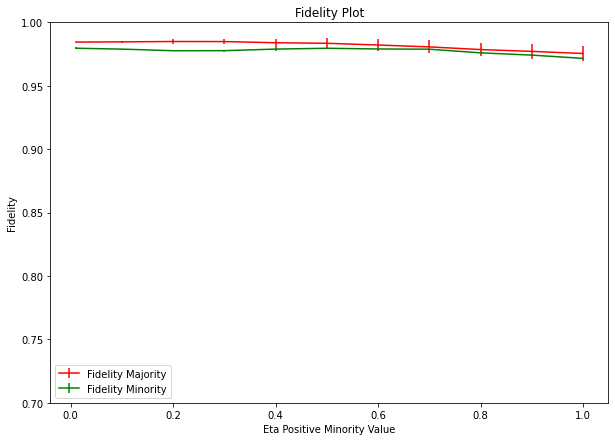

In [220]:
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, 1-mean_fidel_maj7, yerr = y_err_fidel_maj7, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, 1-mean_fidel_min7, yerr = y_err_fidel_min7, label = 'Fidelity Minority', color = "green")
plt.xlabel("Eta Positive Minority Value")
plt.ylabel("Fidelity")
plt.ylim(0.7, 1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('featnoise_inter.jpg')
plt.show()

In [221]:
# below is for diff base rates

In [222]:
np.random.seed(42)
classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'l2')

effect_param_maj = [-0.7, 0.5, 1.5]
effect_param_min = [0.5, -0.2, 0.1]

eta = 0.2
n = 30000

bias_amts, mean_fidel_maj12, mean_fidel_min12, y_err_fidel_maj12, y_err_fidel_min12 = \
measurement(classifier, X_true=X_true, y_true=y_true, \
                       df_train=df_train, sensitive_feature="cat", \
                       apply_fairness=True,verbose=True, num_iters=10, val =False, inter = True)

Diff:  0.20750000000000002
Beta:  0.01 

Num Flipped:  24 	Rate:  0.009603841536614645
Finished Iteration:  0
Beta:  0.1 

Num Flipped:  235 	Rate:  0.0940376150460184
Finished Iteration:  1
Beta:  0.2 

Num Flipped:  471 	Rate:  0.18847539015606243
Finished Iteration:  2
Beta:  0.3 

Num Flipped:  720 	Rate:  0.28811524609843936
Finished Iteration:  3
Beta:  0.4 

Num Flipped:  968 	Rate:  0.3873549419767907
Finished Iteration:  4
Beta:  0.5 

Num Flipped:  1221 	Rate:  0.4885954381752701
Finished Iteration:  5
Beta:  0.6 

Num Flipped:  1483 	Rate:  0.59343737494998
Finished Iteration:  6
Beta:  0.7 

Num Flipped:  1749 	Rate:  0.6998799519807923
Finished Iteration:  7
Beta:  0.8 

Num Flipped:  1999 	Rate:  0.7999199679871949
Finished Iteration:  8
Beta:  0.9 

Num Flipped:  2248 	Rate:  0.8995598239295718
Finished Iteration:  9
Beta:  1.0 

Num Flipped:  2499 	Rate:  1.0
Finished Iteration:  10
Finished Total Iteration:  1
Diff:  0.20344999999999996
Num Flipped:  26 	Rate:  0.01020

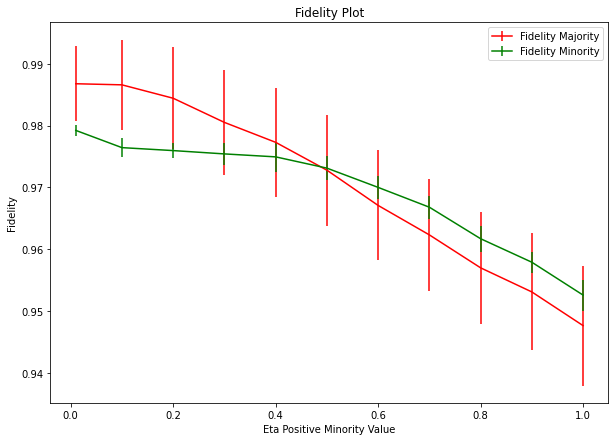

In [223]:
bias_amts = np.divide(list(range(0,11,1)),10)
bias_amts[0] = 0.01 # doesn't work with 0

plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, 1-mean_fidel_maj12, yerr = y_err_fidel_maj12, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, 1-mean_fidel_min12, yerr = y_err_fidel_min12, label = 'Fidelity Minority', color = "green")
plt.xlabel("Eta Positive Minority Value")
plt.ylabel("Fidelity")
plt.ylim(0.7,1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('featnoise_diff.jpg')
plt.show()